## Load dataset 

In [1]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('Training examples:',len(x_train))
print('Test examples:', len(y_train))

Using TensorFlow backend.


Training examples: 50000
Test examples: 50000


## Visualise dataset

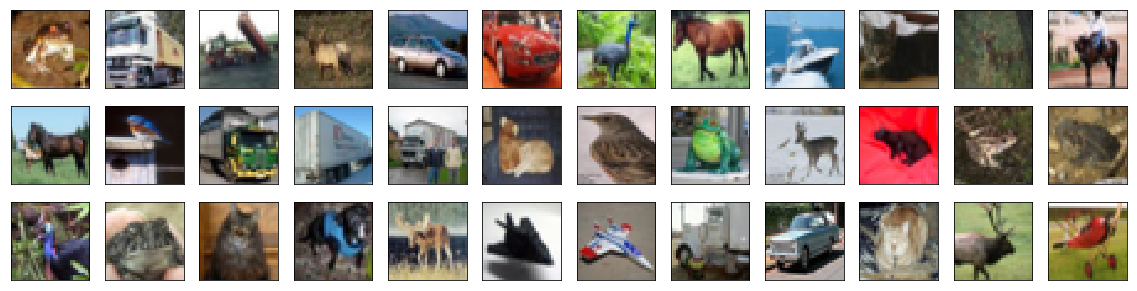

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

## Scale the data 

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## Split the data in train, test and validation sets. One-hot encoding 

In [4]:
import numpy as np
from keras.utils import np_utils

(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('Train samples:', len(x_train))
print('Validation samples:', len(x_valid))

num_classes = len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)

Train samples: 45000
Validation samples: 5000


## Create and configure an Image Generator for augmentation 

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True)

datagen.fit(x_train)

## Visualise some data augmented 

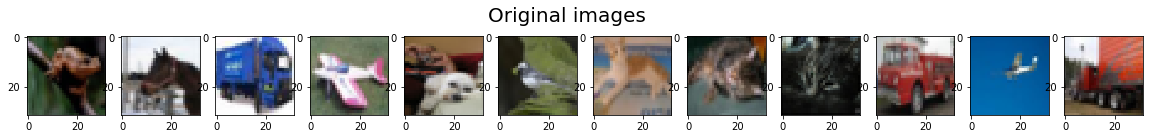

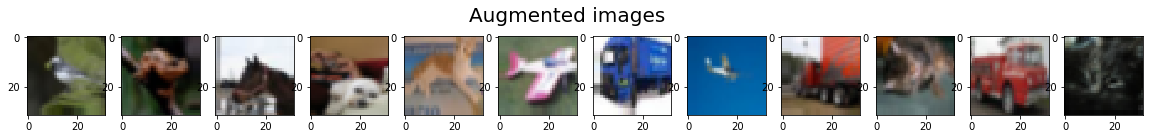

In [6]:
import matplotlib.pyplot as plt

x_train_subset = x_train[:12]
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
    
fig.suptitle('Original images', fontsize=20)
plt.show()

fig = plt.figure(figsize=(20,2))
for batches in datagen.flow(x_train_subset, batch_size=12):
    for i in range(12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(batches[i])
    break
fig.suptitle('Augmented images', fontsize=20)
plt.show()

## Defining the model 

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

## Compiling the model

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Training the model 

In [9]:
from keras.callbacks import ModelCheckpoint

epochs = 30
batch_size = 32

checkpointer = ModelCheckpoint(filepath='aug_cnn_cifar.hdf5', verbose=1, save_best_only=True)
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(x_valid, y_valid),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/30
 - 433s - loss: 1.6159 - acc: 0.4125 - val_loss: 1.2142 - val_acc: 0.5566

Epoch 00001: val_loss improved from inf to 1.21421, saving model to aug_cnn_cifar.hdf5
Epoch 2/30
 - 418s - loss: 1.2534 - acc: 0.5545 - val_loss: 1.2350 - val_acc: 0.5876

Epoch 00002: val_loss did not improve from 1.21421
Epoch 3/30
 - 409s - loss: 1.1316 - acc: 0.6030 - val_loss: 1.0827 - val_acc: 0.6446

Epoch 00003: val_loss improved from 1.21421 to 1.08271, saving model to aug_cnn_cifar.hdf5
Epoch 4/30
 - 415s - loss: 1.0946 - acc: 0.6241 - val_loss: 1.4984 - val_acc: 0.5654

Epoch 00004: val_loss did not improve from 1.08271
Epoch 5/30
 - 410s - loss: 1.0907 - acc: 0.6295 - val_loss: 0.8932 - val_acc: 0.7024

Epoch 00005: val_loss improved from 1.08271 to 0.89324, saving model to aug_cnn_cifar.hdf5
Epoch 6/30
 - 489s - loss: 1.1170 - acc: 0.6281 - val_loss: 0.8845 - val_acc: 0.7176

Epoch 00006: val_loss improved from 0.89324 to 0.88454, saving model to aug_cnn_cifar.hdf5
Epoch 7/30
 - 428s - l

## Loading the best model 

In [12]:
model.load_weights('aug_cnn_cifar.hdf5')

## Test the model 

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score[0])

0.9092898924827576
